# **Cassava VGG11 fine-tuning**
2021/01/12 written by T.Yonezu

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader, Dataset

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import glob 
import os
from tqdm import tqdm

from cassava_dataset import *
from myvgg import *
from augmentation import *

import warnings
warnings.simplefilter('ignore')

In [2]:
input_dir = os.path.join('..',"..", 'input', 'cassava-leaf-disease-classification')

## **Fine-tuning**

In [3]:
x = pd.read_csv(os.path.join(input_dir, 'train.csv'))
x["image_path"] = os.path.join(input_dir,"train_images")
x["image_path"] = x["image_path"].str.cat(x["image_id"], sep=os.path.sep)


from sklearn.model_selection import train_test_split

train_df , valid_df = train_test_split(x,test_size=0.33, random_state=42)
train_df = EqualizeLabels(train_df,NUM=15000)

train_dict = dict( zip(train_df["image_path"],train_df["label"]) )
valid_dict = dict( zip(valid_df["image_path"],valid_df["label"]) )

In [4]:
BATCH_SIZE = 3
size = (512,512)
mean = [0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform = ImageTransform(size,mean,std)
train_data = CassavaDataset(train_dict,transform=transform,phase="train")
train_data = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)

valid_data = CassavaDataset(valid_dict,transform=transform,phase="val")
valid_data = DataLoader(valid_data,batch_size=BATCH_SIZE)

In [5]:
EPOCH_NUM = 10

OUT_DIR = os.path.join("..","..","input","cassava-models")
MODEL_NAME = "VGG11_cassava(512x512)_EqualizedLabel_finetuned_%dEpoch.mdl"
PATH = os.path.join(OUT_DIR,MODEL_NAME%EPOCH_NUM)

In [6]:
import torchvision.models as models

model = models.vgg11(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=5, bias=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

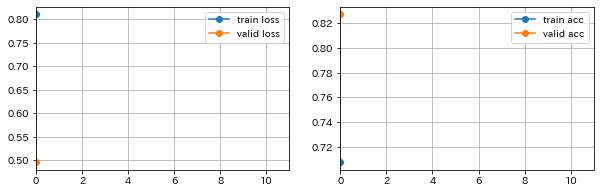

 10%|████████                                                                        | 1/10 [11:43<1:45:31, 703.52s/it]

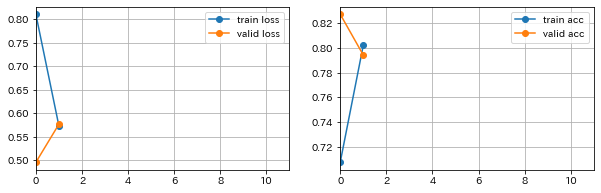

 20%|████████████████                                                                | 2/10 [23:22<1:33:36, 702.07s/it]

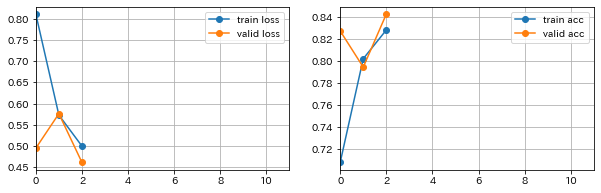

 30%|████████████████████████                                                        | 3/10 [35:00<1:21:46, 700.89s/it]

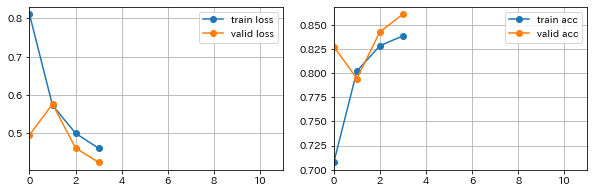

 40%|████████████████████████████████                                                | 4/10 [46:42<1:10:07, 701.33s/it]

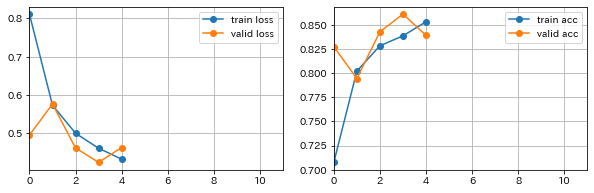

 50%|█████████████████████████████████████████                                         | 5/10 [58:23<58:25, 701.05s/it]

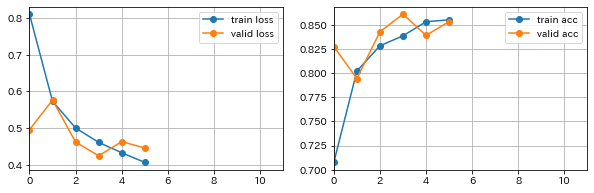

 60%|████████████████████████████████████████████████                                | 6/10 [1:10:04<46:44, 701.11s/it]

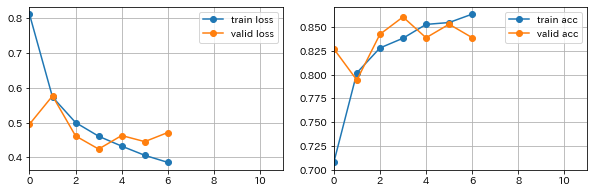

 70%|████████████████████████████████████████████████████████                        | 7/10 [1:21:44<35:02, 700.79s/it]

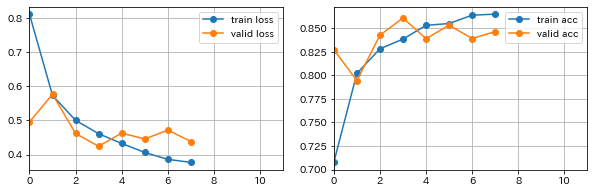

 80%|████████████████████████████████████████████████████████████████                | 8/10 [1:33:27<23:22, 701.44s/it]

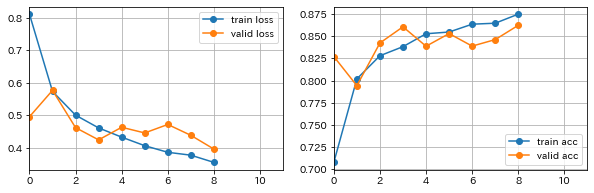

 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [1:45:10<11:41, 701.88s/it]

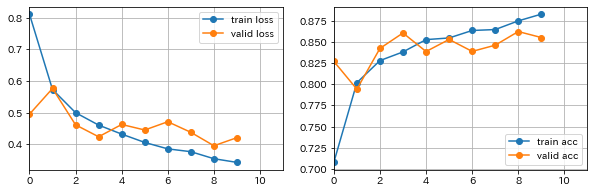

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:56:50<00:00, 701.01s/it]


In [7]:
import torch.optim as optim
from torch import nn

model = model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

log = {}

torch.backends.cudnn.benchmark = True
for epoch in tqdm(range(EPOCH_NUM)):
    
    model.train()
    train_acc = 0
    train_loss = 0
    for batch in (train_data):
        
        X = batch[0].cuda()
        y = batch[1].cuda()
        pred = model(X)
        
        # zero the gradient buffers
        optimizer.zero_grad()
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step() # Does the update
        
        pred_label = ( pred.argmax(axis=1) ).cpu().numpy()
        y = y.cpu().numpy()
        train_acc += (pred_label == y).sum()
        train_loss += loss.item() * X.size(0)
        
    train_acc = train_acc/len(train_data.dataset)
    train_loss = train_loss/len(train_data.dataset)
    
    
    model.eval()
    valid_acc = 0
    valid_loss = 0
    for batch in (valid_data):
        
        X = batch[0].cuda()
        y = batch[1].cuda()
        pred = model(X)
        
        loss = criterion(pred, y)
        
        pred_label = ( pred.argmax(axis=1) ).cpu().numpy()
        y = y.cpu().numpy()
        
        valid_acc += (pred_label == y).sum()
        valid_loss += loss.item() * X.size(0)
    
    valid_acc = valid_acc/len(valid_data.dataset)
    valid_loss = valid_loss/len(valid_data.dataset)
    
    
    log[epoch] = [train_acc, train_loss, valid_acc, valid_loss]
    
    if epoch%1 == 0:
        log_df = pd.DataFrame.from_dict(log,
                                        orient="index",
                                        columns=["train acc","train loss","valid acc","valid loss"])
        
        fig = plt.figure(figsize=(10,3))
        
        ax = fig.add_subplot(1,2,1)
        log_df[["train loss","valid loss"]].plot(marker="o",ax=ax)
        ax.set_xlim(0,EPOCH_NUM+1)
        ax.grid(True)
        
        ax2 = fig.add_subplot(1,2,2)
        log_df[["train acc","valid acc"]].plot(marker="o",ax=ax2)
        ax2.grid(True)
        ax2.set_xlim(0,EPOCH_NUM+1)
        
        plt.show()
        
        

if not(os.path.exists(OUT_DIR)):
    os.makedirs(OUT_DIR)
torch.save(model.state_dict(),PATH)